# A brief primer on conjuage priors

This post attempts to indroduce conjugate priors and give some intuition as to why they work. While this post focuses largely on the technical details of conjugate priors, my next post will focus on conjugate priors in practice.

Consider the well known equation expressing Bayes' theorem

\begin{equation}
P(\theta \ \vert \ D) = \frac{P(D \ \vert \ \theta)P(\theta)}{P(D)}
\end{equation}

In the case of Bayesian inference,

- $\theta$ are our model parameters
- $D$ is data we have observed
- $P(\theta \ \vert \ D)$ is known as the _posterior probability_
- $P(\theta)$ is known as the _prior probability_
- $P(D \ \vert \ \theta)$ is the likelihood of our model

Recall that the goal of Bayesian inference is to treat $\theta$ as a random variable and we typically search for the values of $\theta$ which maximize the posterior probability. Since $P(D)$ is constant for all $\theta$ we usually ignore this term and simply focus on the likelihood times the prior probability (in fact, in this post we'll ignore all constants), i.e.

\begin{equation}
P(\theta \ \vert \ D) \propto P(D \ \vert \ \theta)P(\theta)
\end{equation}

Typically this is hard or impossible to calculate analytically so we resort to numeric methods such as markov chain monte carlo methods.

Enter conjugate priors. A conjugate prior is a prior that "fits" our model in such that we _can_ compute the posterior exactly from the values of our data and model parameters. That is, conjugate priors allow us to analytically derive an expression $f$ such that

\begin{equation}
P(\theta \ \vert \ D) \propto f(\theta, D)
\end{equation}

# Intuition

In all cases the likelihood is the key to understanding how the conjugate prior is derived. Indeed, as stated above we choose the prior _precisely_ so that its probability multiplies nicely with the likelihood. In the example below we'll calculate the likelihood of a particular model. Once we have the likelihood calculated the choice of the prior becomes clear. While we'll specifically look at the Poisson distribution you could follow this same approach for any distribution although in practice you don't need to do this, instead you can just reference [this wiki page](https://en.wikipedia.org/wiki/Conjugate_prior).

## An example

As an example, we'll consider the Poisson distribution, and it's conjugate prior the Gamma distribution.

First let's define our model.

$$
\begin{align}
&D\sim \text{Poi}(\lambda)\\
&\lambda\sim \Gamma(\alpha, \beta) \\
&\alpha,\beta\text{ constants}
\end{align}
$$

Note that in our model $\alpha,\beta$ are not random variables as is $\lambda$ is, but fixed and defined before we observe $D$.

We begin by calculating the likelihood
\begin{align}
P(D\ \vert \ \lambda)&=\prod_{x_{i}\in D}^{}{\frac{\lambda^{x_{i}}e^{-\lambda}}{\lambda!}} \\
&\propto\prod_{x_{i}\in D}^{}{\lambda^{x_{i}}e^{-\lambda}} \\
&\propto\lambda^{\sum_{x_{i}}^{n}{x_{i}}}e^{-n\lambda}
\end{align}

Plugging this into our equation above

$$
\begin{equation}
P(\lambda\ \vert \ D)\propto\left(\lambda^{\sum_{i=1}^{n}{x_{i}}}e^{-n\lambda}\right)P(\lambda)
\end{equation}
$$

Now we can consider sensible choices for our prior, i.e. any distribution that plays nice with this formula for the posterior probability. As we can see, given a fixed $\lambda$, we'll have two parameters that vary in the equation above, i.e. both of the exponents. Thus a distribution with a pdf like the following should do the trick

$$f(\lambda;\alpha,\beta)\propto \lambda^{\alpha}e^{-\beta\lambda}$$

Which, of course, is satisifed by the Gamma distribution and gives us the final calculation of the posterior probability

$$
\begin{equation}
P(\lambda\ \vert \ D)\propto\lambda^{\sum_{i=1}^{n}{x_{i}+\alpha}}e^{-(n+\beta)\lambda}
\end{equation}
$$

or

$$
\begin{equation}
P(\lambda\ \vert \ D)\propto\Gamma(\alpha^{\prime},\beta^{\prime})
\end{equation}
$$

where

$$
\begin{align}
&\alpha^{\prime}=\sum_{i=1}^{n}{x_{i}+\alpha} \\
&\beta^{\prime}=n+\beta
\end{align}
$$

Now let's write some code with that demonstrates how this works.

MAP λ: 5.019959800401995


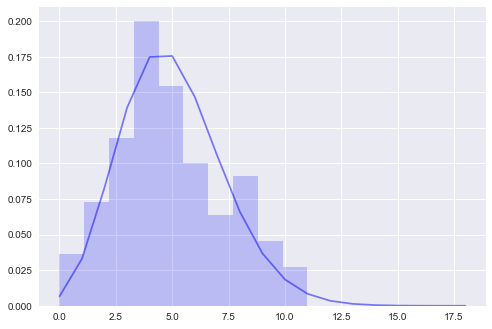

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import utils

# sample from poisson distribution to create D
observations = ss.poisson(5).rvs(size=100)

# define our priors, make them "uninformative"
alpha_prior = beta_prior = 0.001

# calculate the parameters of the posterior distribution according
# to the formula we derived above
alpha_posterior = sum(observations) + alpha_prior
beta_posterior = len(observations) + beta_prior
lambda_posterior = ss.gamma(alpha_posterior, scale=1/beta_posterior)

# take the MAP of the prior on lambda to get the "most likely"
# distribution fitting our observed data
map_lambda = lambda_posterior.mean()
print('MAP λ:', map_lambda)
map_posterior = ss.poisson(map_lambda)

f, ax = plt.subplots()
ax.hist(observations, bins=10, color='b', alpha=0.2, density=True)
utils.plot_pdf(map_posterior, discrete=True, ax=ax)

# Final remarks

There a few things to consider in conclusion.

Having a closed form expression for the posterior probability of a model that can be updated with new data can be very useful, see my next post for an example. However, it is important to note that it is not always appropriate to define our models in such a way.

I'll give two reasons explaining why. The first is that the conjugate prior was only determined because of its analytical convenience _not_ because it seemed appropriate given a specific problem or specific data. The second is that we can only find conjugate priors for simple models. I suppose this is why some people, for example why the stan authors, [don't care much for conjugate prios](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations#general-principles).